In [1]:
from google.colab import files
uploades = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk
import re
import re,string,unicodedata
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [5]:
df.shape

(28619, 3)

In [6]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
df.describe(include='object')

,headline,article_link
count,28619,28619
unique,28503,28617
top,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,12,2


In [8]:
df['headline'].duplicated().sum()

116

In [9]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

In [10]:
# Feature and label extraction

features = df['headline']
labels = df['is_sarcastic']

In [11]:
#stemming of features

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

features = features.apply(lambda x: x.split())
features = features.apply(lambda x:' '.join([ps.stem(word) for word in x]))

Stemming is the process of reducing a word to its stem that affixes to suffixes and prefixes or the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP) 

for example: 'housing' or 'housed'

after stemming would be : 'house'

In [12]:
#preprocessing 

def prepocess_signs(text):

  #remove URLs
  text= re.sub(r'https\S+','',text)

  #remove mentions and hashtags
  text = re.sub(r'@\w+|#\w+','',text)

  #remove punctuation and convert to lowercase
  text = text.translate(str.maketrans('','',string.punctuation)).lower()

  #remove extra whitespace
  text = re.sub('\s+',' ',text).strip()

  return text

In [13]:
df['headline'] = df['headline'].apply(prepocess_signs)

In [14]:
import nltk
nltk.download('stopwords')

# Concatenate all tweet texts into a single string
all_text = ' '.join(df['headline'].values)

# split the text into individual words
words = all_text.split()

#remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
from collections import Counter
#count the frequency of each word
word_counts = Counter(words)

In [16]:
top_words = word_counts.most_common(20)
top_words

[('new', 1674),
 ('trump', 1389),
 ('man', 1363),
 ('us', 601),
 ('report', 600),
 ('one', 554),
 ('woman', 503),
 ('area', 488),
 ('donald', 475),
 ('says', 474),
 ('day', 473),
 ('time', 453),
 ('like', 445),
 ('first', 435),
 ('get', 434),
 ('trumps', 405),
 ('people', 403),
 ('house', 390),
 ('life', 370),
 ('still', 368)]

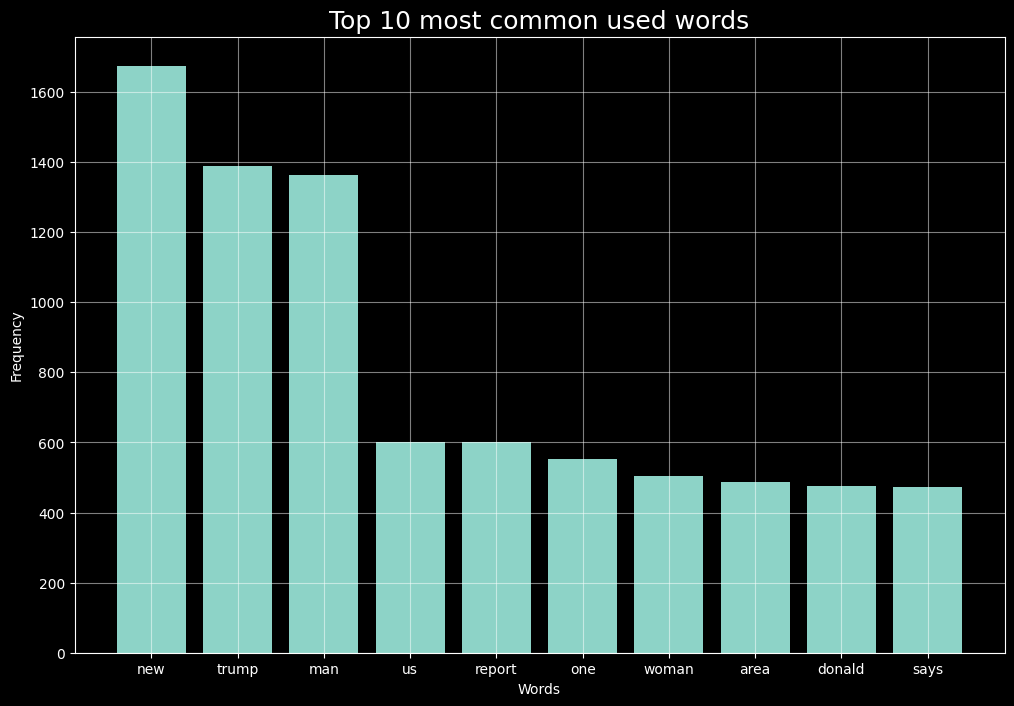

In [17]:
# Visualize the most common words

top_words = dict(word_counts.most_common(10))

#dark background
plt.style.use('dark_background')
plt.figure(figsize=(12,8))

#create the barplot
plt.bar(range(len(top_words)),list(top_words.values()),align='center')

plt.xticks(range(len(top_words)),list(top_words.keys()))

#grid opacity
plt.grid(alpha=0.5)

#title
plt.title('Top 10 most common used words', fontsize=18)

#labels
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

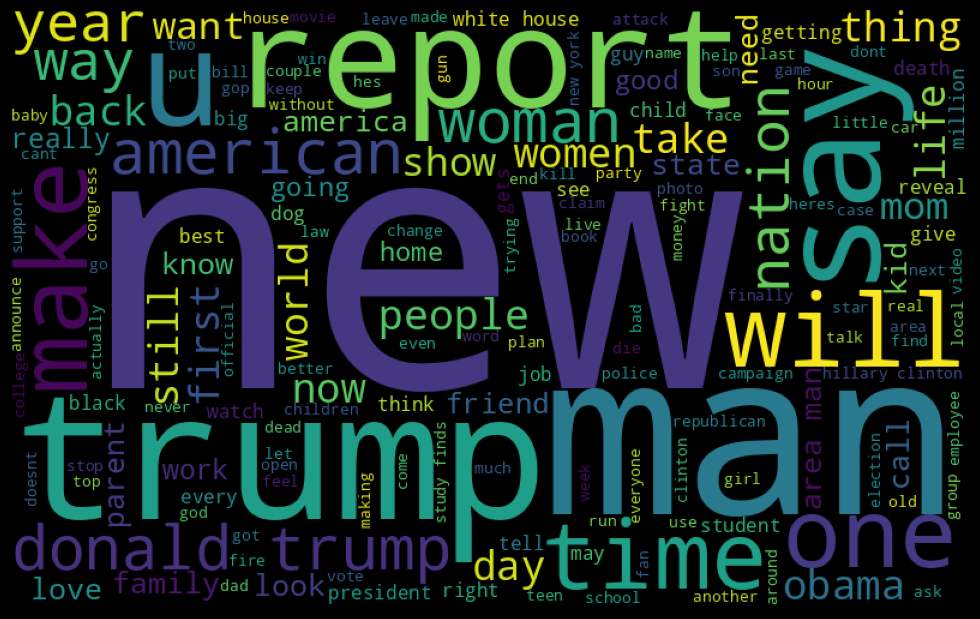

In [18]:
from wordcloud import WordCloud

#word graph
text = ' '.join(caption for caption in df['headline'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'black',
                       min_font_size = 10).generate(text)

plt.figure(figsize = (10,6),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [19]:
#vectorizing the data with maximum of 5000 features
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features =5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, test_size =0.05, random_state =0)

In [21]:
#count the number of instances in each class
class_counts = df['is_sarcastic'].value_counts()

#print the class distribution 
print('Class distribution:')
print(class_counts)

Class distribution:
0    14951
1    13552
Name: is_sarcastic, dtype: int64


In [22]:

from pycaret.classification import *
from imblearn.over_sampling import SMOTE

import string

import spacy
from tqdm.auto import tqdm
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00

In [24]:
s = setup(data=df, target='is_sarcastic', session_id=123, normalize=True)

,Description,Value
0,Session id,123
1,Target,is_sarcastic
2,Target type,Binary
3,Original data shape,"(28503, 3)"
4,Transformed data shape,"(28503, 3)"
5,Transformed train set shape,"(19952, 3)"
6,Transformed test set shape,"(8551, 3)"
7,Categorical features,2
8,Preprocess,True
9,Imputation type,simple


In [25]:
compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.3210
knn,K Neighbors Classifier,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.7310
nb,Naive Bayes,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0650
dt,Decision Tree Classifier,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7840
ridge,Ridge Classifier,0.5246,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9580
rf,Random Forest Classifier,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.5610
qda,Quadratic Discriminant Analysis,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7820
ada,Ada Boost Classifier,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0590
gbc,Gradient Boosting Classifier,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.4320
lda,Linear Discriminant Analysis,0.5246,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0380


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [27]:
# train a Logistic Regression Model
clf = LogisticRegression()

In [29]:
clf.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_pred = clf.predict(xtest)

In [31]:
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [33]:
acc = accuracy_score(ytest, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8274894810659187


<Axes: >

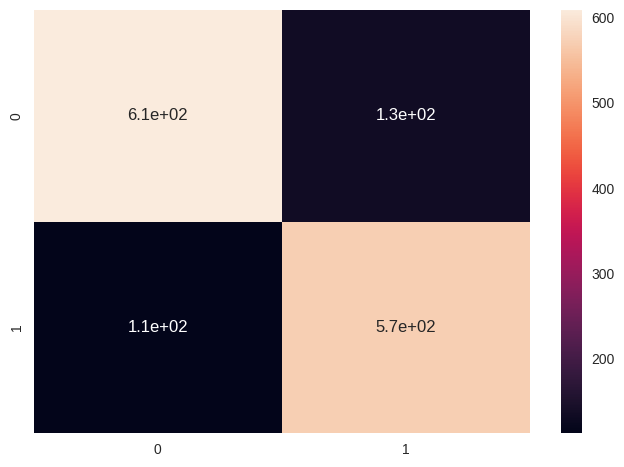

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True)

In [35]:
#Decision Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [36]:
# train a Decision Tree classifier
dt = DecisionTreeClassifier()
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

In [37]:
dt.fit(xtrain, ytrain)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

In [38]:
y_pred = dt.predict(xtest)
y_pred

array([0, 0, 1, ..., 1, 0, 1])

In [39]:
acc = accuracy_score(ytest, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7342215988779803


<Axes: >

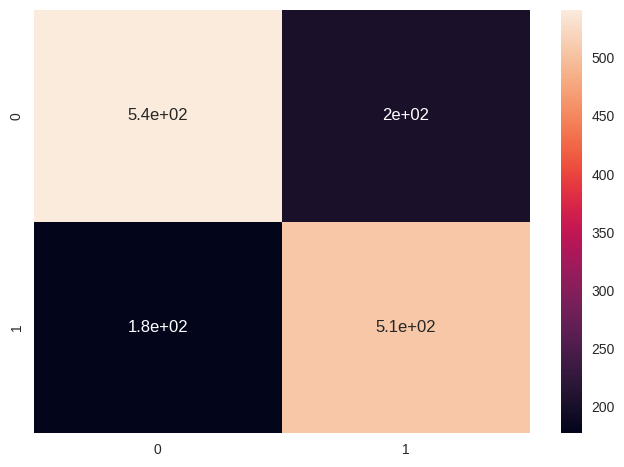

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True)

In [41]:
#Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# train a Naive Bayes classifier
mnb = MultinomialNB()
mnb

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True, force_alpha='warn')

In [42]:
mnb.fit(xtrain, ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True, force_alpha='warn')

In [44]:
# evaluate the classifier on the test set
y_pred = mnb.predict(xtest)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [46]:
acc = accuracy_score(ytest, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8134642356241234


<Axes: >

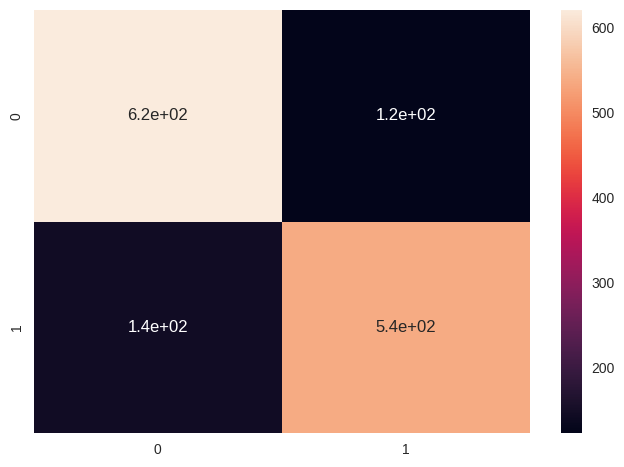

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True)

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [50]:
# train K Neighbors Classifier
neigh = KNeighborsClassifier()
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [51]:
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [52]:
y_pred = neigh.predict(xtest)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
acc = accuracy_score(ytest, y_pred)
print("Accuracy:", acc)

Accuracy: 0.5336605890603086


<Axes: >

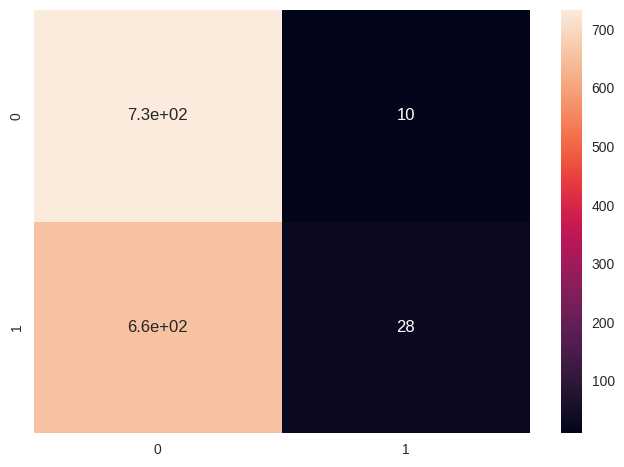

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True)